In [1]:
# prompt: mount drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!pip install torch torchvision
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!pip install -r requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 17778, done.
remote: Counting objects: 100% (154/154), done.
remote: Compressing objects: 100% (103/103), done.
remote: Total 17778 (delta 98), reused 51 (delta 51), pack-reused 17624 (from 4)
Receiving objects: 100% (17778/17778), 17.14 MiB | 9.56 MiB/s, done.
Resolving deltas: 100% (12077/12077), done.
/content/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 36.3 MB/s eta 0:00:00


In [3]:
from google.colab import files
uploaded = files.upload()  # This will prompt you to upload a file
input_video_path = list(uploaded.keys())[0]

Saving video2.mp4 to video2.mp4


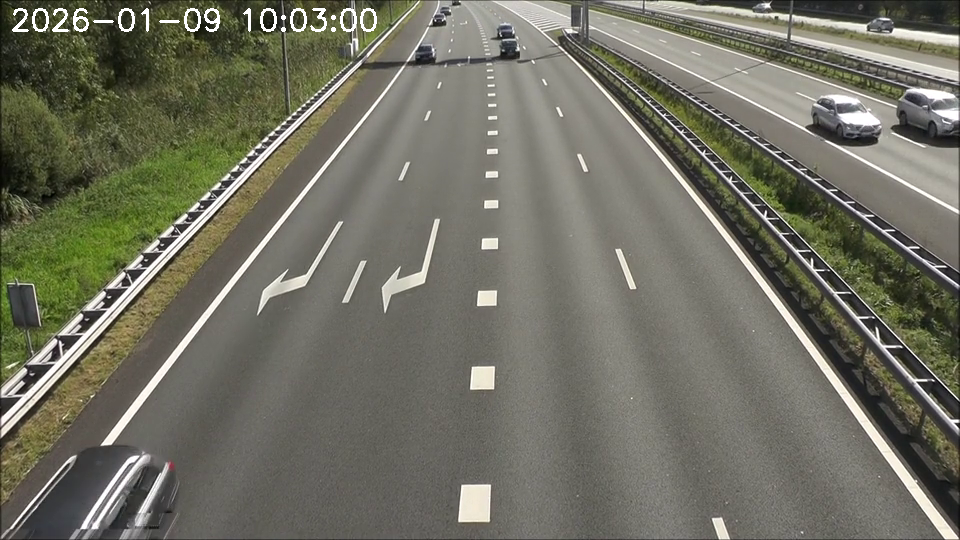

In [4]:

import torch
import cv2
import time
import numpy as np
from datetime import datetime
from google.colab.patches import cv2_imshow
from IPython.display import clear_output
import logging

class VideoVehicleDetector:
    def __init__(self, model_size='yolov5s', confidence_threshold=0.5, motion_threshold=30, blur_size=21):
        self.confidence_threshold = confidence_threshold
        self.motion_threshold = motion_threshold
        self.blur_size = blur_size

        # Define vehicle classes and colors
        self.vehicle_classes = {2: 'car', 3: 'motorcycle', 5: 'bus', 7: 'truck'}
        self.color_map = {'car': (0, 255, 0), 'motorcycle': (255, 0, 0), 'bus': (0, 0, 255), 'truck': (255, 255, 0)}

        # Load YOLOv5 model
        self.model = torch.hub.load('ultralytics/yolov5', model_size, pretrained=True)
        self.model.conf = confidence_threshold
        self.model.classes = list(self.vehicle_classes.keys())

    def detect_motion(self, prev_frame, curr_frame):
        """Detect motion by comparing blurred grayscale frames."""
        prev_blur = cv2.GaussianBlur(cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY), (self.blur_size, self.blur_size), 0)
        curr_blur = cv2.GaussianBlur(cv2.cvtColor(curr_frame, cv2.COLOR_BGR2GRAY), (self.blur_size, self.blur_size), 0)
        motion_mask = cv2.threshold(cv2.absdiff(prev_blur, curr_blur), self.motion_threshold, 255, cv2.THRESH_BINARY)[1]
        return np.sum(motion_mask) > 0, cv2.morphologyEx(motion_mask, cv2.MORPH_CLOSE, np.ones((5, 5), np.uint8))

    def detect_vehicles(self, frame):
        """Detect vehicles using YOLOv5."""
        results = self.model(frame)
        return [{'bbox': det[:4].tolist(), 'confidence': det[4].item(), 'class_name': self.vehicle_classes[int(det[5])]}
                for det in results.xyxy[0] if det[4] >= self.confidence_threshold]

    def draw_detections(self, frame, detections, motion_mask=None):
        """Draw bounding boxes and motion overlay."""
        frame = cv2.addWeighted(frame, 1, cv2.cvtColor(motion_mask, cv2.COLOR_GRAY2BGR), 0.3, 0) if motion_mask is not None else frame
        for det in detections:
            x1, y1, x2, y2 = map(int, det['bbox'])
            label = f"{det['class_name']} {det['confidence']:.2f}"
            cv2.rectangle(frame, (x1, y1), (x2, y2), self.color_map[det['class_name']], 2)
            cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, self.color_map[det['class_name']], 2)
        cv2.putText(frame, datetime.now().strftime("%Y-%m-%d %H:%M:%S"), (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
        return frame

    def process_video(self, input_source, output_path, display_frequency=30):
        """Process a video, detect vehicles and save the output."""
        cap, out = cv2.VideoCapture(input_video_path), None
        frame_count, prev_frame = 0, None
        if not cap.isOpened():
            raise ValueError(f"Failed to open video source: {input_source}")

        # Video writer setup
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        frame_width, frame_height = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps = int(cap.get(cv2.CAP_PROP_FPS))
        out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            frame_count += 1
            if prev_frame is None:
                prev_frame = frame.copy()
                continue

            motion_detected, motion_mask = self.detect_motion(prev_frame, frame)
            detections = self.detect_vehicles(frame) if motion_detected else []
            annotated_frame = self.draw_detections(frame, detections, motion_mask)
            out.write(annotated_frame)

            if frame_count % display_frequency == 0:
                clear_output(wait=True)
                cv2_imshow(annotated_frame)

            prev_frame = frame.copy()

        cap.release()
        out.release()
        logging.info(f"Video processing completed. Output saved to: {output_path}")


def main():
    logging.basicConfig(level=logging.INFO)
    detector = VideoVehicleDetector()
    detector.process_video("input_video.mp4", "output_video.mp4")


if __name__ == "__main__":
    main()


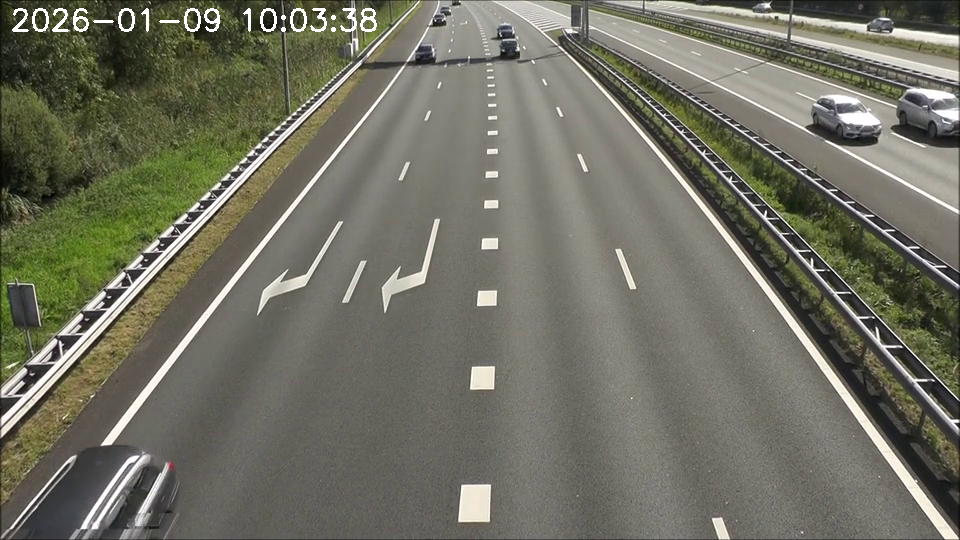

In [5]:
detector = VideoVehicleDetector()
detector.process_video(
    input_source=input_video_path,
    output_path="detected_output.mp4",
    display_frequency=30
)

In [6]:
files.download('detected_output.mp4')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>